# InceptionTime Model 
# on Time Series EMG Classification on Ninapro Dataset [Wrist Motions]

InceptionTime is a 1D Convolution based Deep Neural Network model which is currently quoted as the state of the art TSC model from the published paper [InceptionTime: Finding AlexNet for Time Series Classification](https://arxiv.org/abs/1909.04939).

#### Understanding Data
Input data will be a 2D matrix which has rows as the time-step and columns as emg channels.
Window Length X No.EMG Sensors

#### Model Accuracy  Results

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import glob
import warnings
from tqdm.notebook import trange, tqdm
# from keras.utils import to_categorical
from random import randrange
# warnings.filterwarnings(action='once')
# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')

## Import the Prepared Datasets

In [2]:
win_len = 250

In [109]:
X = np.load('prepared_data/norest_X_all_wrist_{}_40.npy'.format(win_len))
y = np.load('prepared_data/norest_Y_hot_all_wrist_{}_40.npy'.format(win_len))
Y_stim = np.load('prepared_data/norest_Y_all_wrist_{}_40.npy'.format(win_len))

In [110]:
X = np.reshape(X,(X.shape[0],X.shape[1],X.shape[2]))
X.shape

(370616, 250, 12)

In [111]:
y.shape

(370616, 9)

In [4]:
y_true = []
for d in y_test:
    idx = list(d).index(1)
    y_true.append(idx)

### Data Bias Check (Remove Rest Bias)

In [113]:
def countX(lst, x): 
    count = 0
    for ele in lst: 
        if (ele == x): 
            count = count + 1
    return count 

### Merge, Shuffle and Split

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True)

##### Keep only 8 EMG data

In [115]:
def rm_columns(X,n):
#     X_r = list(np.zeros((X.shape[0],X.shape[1],X.shape[2]-n)))
    X_r = []
    for i in tqdm(range(len(X))):
        d = np.copy(X[i])
        for i in range(n):
            d = np.delete(d, -1, 1)
        X_r.append(d)
    return np.array(X_r)

In [116]:
X_train = rm_columns(X_train,4)
X_test = rm_columns(X_test,4)

In [117]:
print('X Train Shape =',X_train.shape)
print('Y Train Shape =',y_train.shape)
print('X Test Shape =',X_test.shape)
print('Y Test Shape =',y_test.shape)

X Train Shape = (296492, 250, 8)
Y Train Shape = (296492, 9)
X Test Shape = (74124, 250, 8)
Y Test Shape = (74124, 9)


## Normalization Section

In [89]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [90]:
def normalize_samples(X):
    scaler = MinMaxScaler()
    X_new = []
    for i in tqdm(range(len(X))):
        d = scaler.fit(X[i])
        X_new.append(scaler.transform(X[i]))
    return np.array(X_new)
scaler = StandardScaler()
def normalize_whole(data):
    num_instances, num_time_steps, num_features = data.shape
    data = np.reshape(data,(-1, num_features))
    data = scaler.fit_transform(data)
    data = np.reshape(data,(num_instances, num_time_steps, num_features))
    return data

In [91]:
X_train = normalize_whole(X_train)
num_instances, num_time_steps, num_features = X_test.shape
X_test = np.reshape(X_test,(-1, num_features))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test,(num_instances, num_time_steps, num_features))

In [92]:
print('X Train Shape =',X_train.shape)
print('Y Train Shape =',y_train.shape)
print('X Test Shape =',X_test.shape)
print('Y Test Shape =',y_test.shape)

X Train Shape = (296492, 250, 8)
Y Train Shape = (296492, 9)
X Test Shape = (74124, 250, 8)
Y Test Shape = (74124, 9)


#### Save and Quick Load Prepared Data
###### Save

In [93]:
np.save('prepared_data/X_train_s40',X_train)
np.save('prepared_data/y_train_s40',y_train)
np.save('prepared_data/X_test_s40',X_test)
np.save('prepared_data/y_test_s40',y_test)

#### Load 

In [3]:
import numpy as np
X_train = np.load('prepared_data/X_train_s40.npy')
y_train = np.load('prepared_data/y_train_s40.npy')
X_test = np.load('prepared_data/X_test_s40.npy')
y_test = np.load('prepared_data/y_test_s40.npy')
print('X Train Shape =',X_train.shape)
print('Y Train Shape =',y_train.shape)
print('X Test Shape =',X_test.shape)
print('Y Test Shape =',y_test.shape)

X Train Shape = (296492, 250, 8)
Y Train Shape = (296492, 9)
X Test Shape = (74124, 250, 8)
Y Test Shape = (74124, 9)


# InceptionTime Trainer

In [6]:
import numpy as np
import sklearn
import pandas as pd
import sys
import subprocess
import tensorflow as tf
from InceptionTime.classifiers.inception import Classifier_INCEPTION

### Build New Model

In [123]:
 clf = Classifier_INCEPTION('', (X_train.shape[1],X_train.shape[2]),nb_classes=9,
                            verbose=True,batch_size=500,nb_epochs=100,nb_filters=16,
                            depth=10, kernel_size=11)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 250, 8)]     0                                            
__________________________________________________________________________________________________
conv1d_106 (Conv1D)             (None, 250, 32)      256         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_20 (MaxPooling1D) (None, 250, 8)       0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_107 (Conv1D)             (None, 250, 16)      5120        conv1d_106[0][0]                 
____________________________________________________________________________________________

## Continue Previous Training Session

In [9]:
from keras.models import load_model
clf = Classifier_INCEPTION('', (X_train.shape[1],X_train.shape[2]),nb_classes=9,
                        verbose=True,batch_size=500,nb_epochs=25,nb_filters=16,
                        depth=10, kernel_size=11)
clf.model = load_model('best_model.hdf5')
clf.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 8)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 250, 32)      256         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 250, 8)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 250, 16)      5120        conv1d[0][0]                     
______________________________________________________________________________________________

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 250, 8)]     0                                            
__________________________________________________________________________________________________
conv1d_106 (Conv1D)             (None, 250, 32)      256         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_20 (MaxPooling1D) (None, 250, 8)       0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_107 (Conv1D)             (None, 250, 16)      5120        conv1d_106[0][0]                 
____________________________________________________________________________________________

In [8]:
df_metrics = clf.fit(X_train, y_train, X_test, y_test, y_true,plot_test_acc=True)

Epoch 1/25
593/593 [==============================] - 122s 205ms/step - loss: 0.1235 - accuracy: 0.9571 - val_loss: 0.3874 - val_accuracy: 0.8827 - lr: 0.0010loss: 0.1161 - accura - ETA: 1:03 - loss: 0.1167 - accuracy - ETA: 1:02 - loss: 0.1166 - accuracy:   - ETA: 55s - los - ETA: 50s - loss -  - ETA: 2s - l
Epoch 2/25
118/593 [====>.........................] - ETA: 1:28 - loss: 0.1117 - accuracy: 0.9607 E - ETA: 1:42 - l

KeyboardInterrupt: 

In [12]:
best_model = load_model('best_model.hdf5')
best_model.save('wrist_model_{}'.format(win_len))

## Plot Results

In [17]:
%matplotlib inline
metrics_df = pd.read_csv('df_metrics.csv')
best_model_df = pd.read_csv('df_best_model.csv')
history_df = pd.read_csv('history.csv')

In [18]:
metrics_df

,precision,accuracy,recall,duration
0,0.8883,0.886649,0.890111,5905.71478


<AxesSubplot:title={'center':'Loss'}>

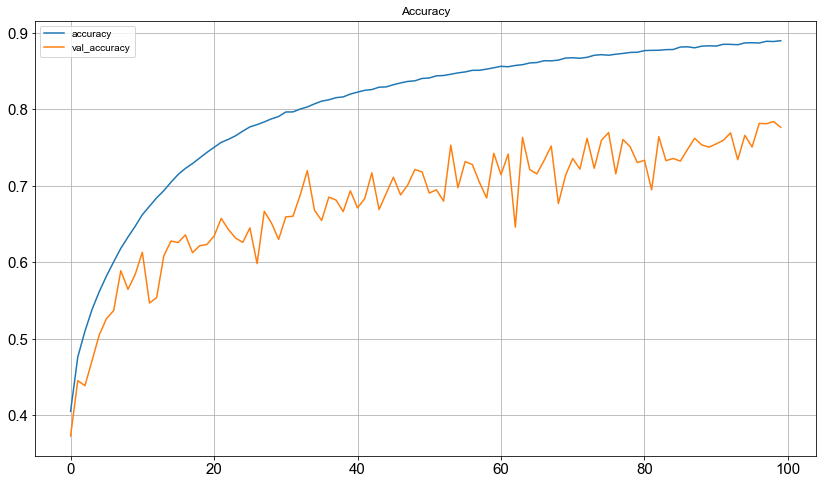

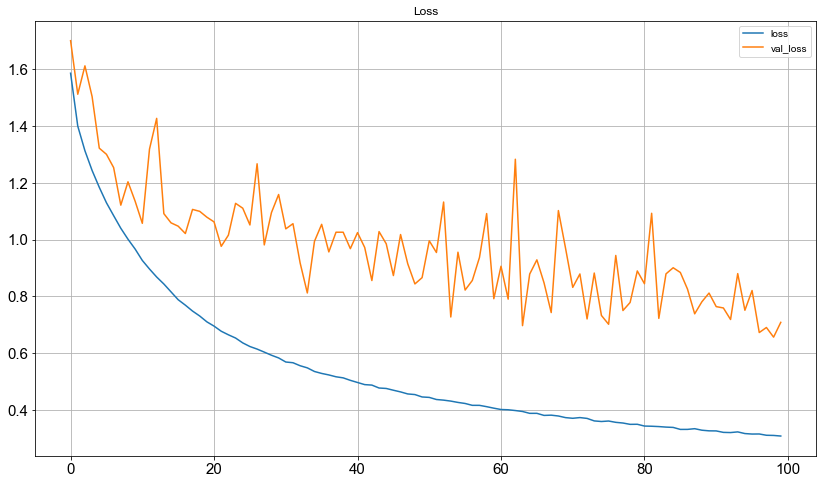

In [127]:
history_df[['accuracy','val_accuracy']].plot(figsize=(14,8),title='Accuracy',grid=True,fontsize=15)
history_df[['loss','val_loss']].plot(figsize=(14,8),title='Loss',grid=True,fontsize=15)

# Import Model and Classify Function Definition

## Real time CNN Classifier Example
**Input Data** - The single Input data matrix sent in 20Khz freaquency,Has rows as time steps and columns as feature

### Input Sequence Data from DF

In [5]:
from keras.models import load_model
model = load_model('wrist_model_250_89')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 250, 8)]     0                                            
__________________________________________________________________________________________________
conv1d_106 (Conv1D)             (None, 250, 32)      256         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_20 (MaxPooling1D) (None, 250, 8)       0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_107 (Conv1D)             (None, 250, 16)      5120        conv1d_106[0][0]                 
____________________________________________________________________________________________

In [6]:
def wrist_classifier(data):
    data = np.array(data) 
    data = np.reshape(data,(1,250,8))
    pred = model.predict(data,batch_size=1)[0]
    print(np.argmax(np.array(pred)))
    print(pred)

In [16]:
n = 5000
print(y_train[n])
wrist_classifier(X_train[n])

[0. 0. 0. 0. 0. 0. 1. 0. 0.]
6
[3.5318153e-04 5.8162299e-05 3.4493253e-01 9.3112690e-03 6.6060475e-03
 9.1784829e-03 5.6783128e-01 1.4509637e-02 4.7219329e-02]


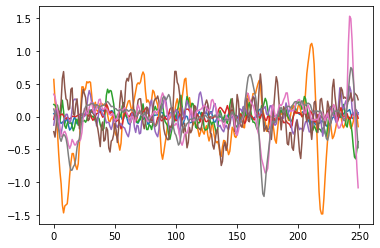

In [17]:
plt.plot(X_train[n])

## Distribution of Labels

In [10]:
def countX(lst, x): 
    count = 0
    for ele in lst: 
        if (ele == x): 
            count = count + 1
    return count
sum = 0
for i in range(9):
    sum = sum+countX(y_true,i)/len(y_true)*100
    print(i,'=',countX(y_true,i)/len(y_true)*100,' %')
print('All ',sum,' %')

0 = 12.810965409314123  %
1 = 12.137769143597216  %
2 = 13.613674383465543  %
3 = 11.34585289514867  %
4 = 9.071285953267498  %
5 = 9.196751389563435  %
6 = 11.43219470077168  %
7 = 11.016674761210945  %
8 = 9.374831363660894  %
All  100.0  %
